<a href="https://colab.research.google.com/github/rennydoig/ssc22-case-comp/blob/main/Daisy_dir/The_mixed_effect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import csv
!pip install geopandas rtree
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/2022 SSC Case Study')
print(os.getcwd())

In [ ]:
def dataAggregation(df, aggregate_by, conType):
    """ Aggregate data by tile, dissemination area, census division or province """
    '''
    df: orginal data in pd.DataFrame
    aggregate_by: 'quadkey' or 'DAUID' or 'CDNAME' or "PRNAME"
    conType: boolen, has the option to seperate connect type (e.g. fixed or mobile)
    '''

    # Weighted average of 'avg_d_mbps', 'avg_u_mbps' and 'avg_lat_ms', weight = 'tests'
    wm = lambda x: np.average(x, weights=df.loc[x.index, 'tests'])

    if conType:
      dat = df.groupby([aggregate_by,'Time','conn_type'],as_index=False).agg({"avg_u_mbps":wm,
                                                                              "avg_d_mbps":wm,
                                                                              "avg_lat_ms":wm,
                                                                              "tests":"sum",
                                                                              "DA_POP":"sum"})
    else: 
      dat = df.groupby([aggregate_by,'Time'],as_index=False).agg({"avg_u_mbps":wm,
                                                                  "avg_d_mbps":wm,
                                                                  "avg_lat_ms":wm,
                                                                  "tests":"sum",
                                                                  "DA_POP":"sum"})

    return dat

In [5]:
df = pd.read_csv("ookla-canada-speed-tiles.csv")
df['avg_d_mbps'] = df['avg_d_kbps'] / 1000
df['avg_u_mbps'] = df['avg_u_kbps'] / 1000

def getTime(i):
  year = i[0]
  quarter = i[1]
  return year + (int(quarter[1:2])-1/4) - 2019
df['Time'] = [getTime(i) for i in zip(df['year'], df['quarter'])]

# Filter only rural areas: rows with NaN for either PCUID, PCNAME, PCTYPE, or PCCLASS
cond = (df['PCUID'].isna()) | (df['PCNAME'].isna()) | (df['PCTYPE'].isna()) | (df['PCCLASS'].isna())
df_rural = df[cond]

data = dataAggregation(df_rural,'CDNAME',False)
maxTime = data['Time'].max()
data_train = data[data['Time'] < maxTime]
data_test = data[data['Time'] == maxTime]

# The mixed effects model

The mixed effects model Yij = β0 + β1Tij + Vi + ϵij, where
*   Yij: download/upload speed for subject j in cluster i
*   Tij: time (fixed effect)
*   Vi: cluster-specific random effect such that Vi ~ N(0, Σ)
*   ϵij: subject-specific random effect such that eij ~ N(0, σ^2I) 

In [109]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## Mixed effects model with random intercept

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_d_mbps
No. Observations: 1183    Method:             REML      
No. Groups:       238     Scale:              120.5980  
Min. group size:  2       Likelihood:         -4942.4158
Max. group size:  5       Converged:          Yes       
Mean group size:  5.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     36.214    2.053 17.641 0.000 32.191 40.238
Time           8.486    0.226 37.580 0.000  8.043  8.929
Group Var    886.310    8.524                           



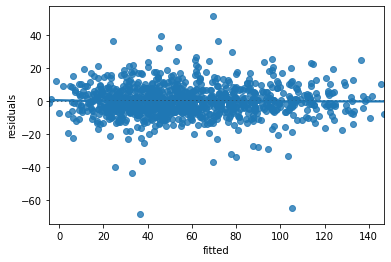

In [260]:
m1 = smf.mixedlm("avg_d_mbps ~ Time", data_train, groups=data_train["CDNAME"])
result = m1.fit(method=["lbfgs"])
print(result.summary())

# Residual plot
performance = pd.DataFrame()
performance["residuals"] = result.resid.values
performance["actual"] = data_train['avg_d_mbps']
performance["fitted"] = result.fittedvalues
ax = sns.residplot(x = "fitted", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='residuals')
plt.show()


In [261]:
# The prediction purely on fixed effects
fix_eff_pred = result.predict(exog=data_test)

# The prediction on random effects
ran_eff_pred = []
# The predicted random effects
for i in range(data_test.shape[0]):
  x = data_test['CDNAME'].iloc[i]
  ran_eff_pred.append(result.random_effects[x])

# Add the fixed and random effects to get the overall prediction
pred = fix_eff_pred + np.concatenate(ran_eff_pred)

# Get RMSE
true = data_test['avg_d_mbps']
print("RMSE: {}".format(np.sqrt(metrics.mean_squared_error(true, pred))))

# Get accuracy
pred_class = [int(p >= 50) for p in pred]
true_class = [int(p >= 50) for p in true]
print("Accuracy: {}".format(accuracy_score(true_class, pred_class, normalize=False)/float(len(true_class))))

# Get confusion matrix
print(metrics.confusion_matrix(true_class, pred_class))

# Get classification report
print(classification_report(true_class,pred_class))

RMSE: 26.079121238371723
Accuracy: 0.9322033898305084
[[  9   9]
 [  7 211]]
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        18
           1       0.96      0.97      0.96       218

    accuracy                           0.93       236
   macro avg       0.76      0.73      0.75       236
weighted avg       0.93      0.93      0.93       236



## Mixed effects model with random slope and random intercept

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  avg_u_mbps
No. Observations:   1183     Method:              REML      
No. Groups:         238      Scale:               40.4091   
Min. group size:    2        Likelihood:          -4444.0186
Max. group size:    5        Converged:           Yes       
Mean group size:    5.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         16.267    1.036 15.705 0.000 14.237 18.298
Time               3.340    0.266 12.536 0.000  2.818  3.862
Group Var        216.080    4.261                           
Group x Time Cov   9.128    0.671                           
Time Var          12.815    0.282                           



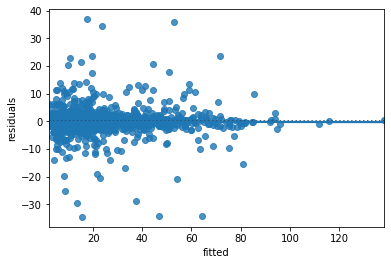

In [256]:
m2 = smf.mixedlm("avg_u_mbps ~ Time", data_train, groups=data_train["CDNAME"], re_formula="~Time")
free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
    np.ones(2), np.eye(2)
)
result = m2.fit(method=["lbfgs"]) 
print(result.summary())

# Residual plot
performance = pd.DataFrame()
performance["residuals"] = result.resid.values
performance["actual"] = data_train['avg_d_mbps']
performance["fitted"] = result.fittedvalues
ax = sns.residplot(x = "fitted", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='residuals')
plt.show()

In [257]:
# The prediction purely on fixed effects
fix_eff_pred = result.predict(exog=data_test)

# The prediction on random effects
ran_eff_pred = []
# The predicted random effects
for i in range(data_test.shape[0]):
  x = data_test['CDNAME'].iloc[i]
  t = data_test['Time'].iloc[i]
  p = result.random_effects[x][0]+t*result.random_effects[x][1]
  ran_eff_pred.append(p)

# Add the fixed and random effects to get the overall prediction
pred = fix_eff_pred + ran_eff_pred

# Get RMSE
true = data_test['avg_d_mbps']
print("RMSE: {}".format(np.sqrt(metrics.mean_squared_error(true, pred))))

# Get accuracy
pred_class = [int(p >= 50) for p in pred]
true_class = [int(p >= 50) for p in true]
print("Accuracy: {}".format(accuracy_score(true_class, pred_class, normalize=False)/float(len(true_class))))

# Get confusion matrix
print(metrics.confusion_matrix(true_class, pred_class))

# Get classification report
print(classification_report(true_class,pred_class))

RMSE: 73.68001855208686
Accuracy: 0.3093220338983051
[[ 18   0]
 [163  55]]
              precision    recall  f1-score   support

           0       0.10      1.00      0.18        18
           1       1.00      0.25      0.40       218

    accuracy                           0.31       236
   macro avg       0.55      0.63      0.29       236
weighted avg       0.93      0.31      0.39       236

